# url: https://toukei-lab.com/gradient-boosting

# 勾配ブースティング木手法をPythonで実装して比較していく！

Xgboostに代わる手法としてLightGBMが登場し、さらにCatboostという手法が2017年に登場いたしました。

これらは弱学習器である決定木を勾配ブースティングによりアンサンブル学習した非常に強力な機械学習手法群。

勾配ブースティングの仲間としてくくられることが多いです。

計算負荷もそれほど重くなく非常に高い精度が期待できるため、Kaggleなどのデータ分析コンペや実務シーンなど様々な場面で頻繁に使用されているのです。

最新のアルゴリズムがどんどん登場するけど、勾配ブースティング×決定木の組み合わせであることは変わらないんだね！

## 勾配ブースティングとは
詳細の数式は他のサイトに譲るとして、この記事では概念的に勾配ブースティングが理解できるように解説していきます。

動画でも勾配ブースティング手法のXGBoostやLightGBMについて解説していますのであわせてチェックしてみてください！

まず、勾配ブースティングは「勾配＋ブースティング」に分解できます。

まずは、ブースティングから見ていきましょう！

機械学習手法には単体で強力な精度をたたき出す「強学習器（SVMとか）」と単体だと弱い「弱学習器（決定木とか）」あります。

弱学習器単体だと、予測精度の悪い結果になってしまいますが複数組みあわせて使うことで強力な予測精度を出力するのです。

それをアンサンブル学習と言います。

そしてアンサンブル学習には大きく分けて2つの方法「バギング」「ブースティング」があります（スタッキングという手法もありますがここではおいておきましょう）。

バギングは並列に弱学習器を使って多数決を取るイメージ

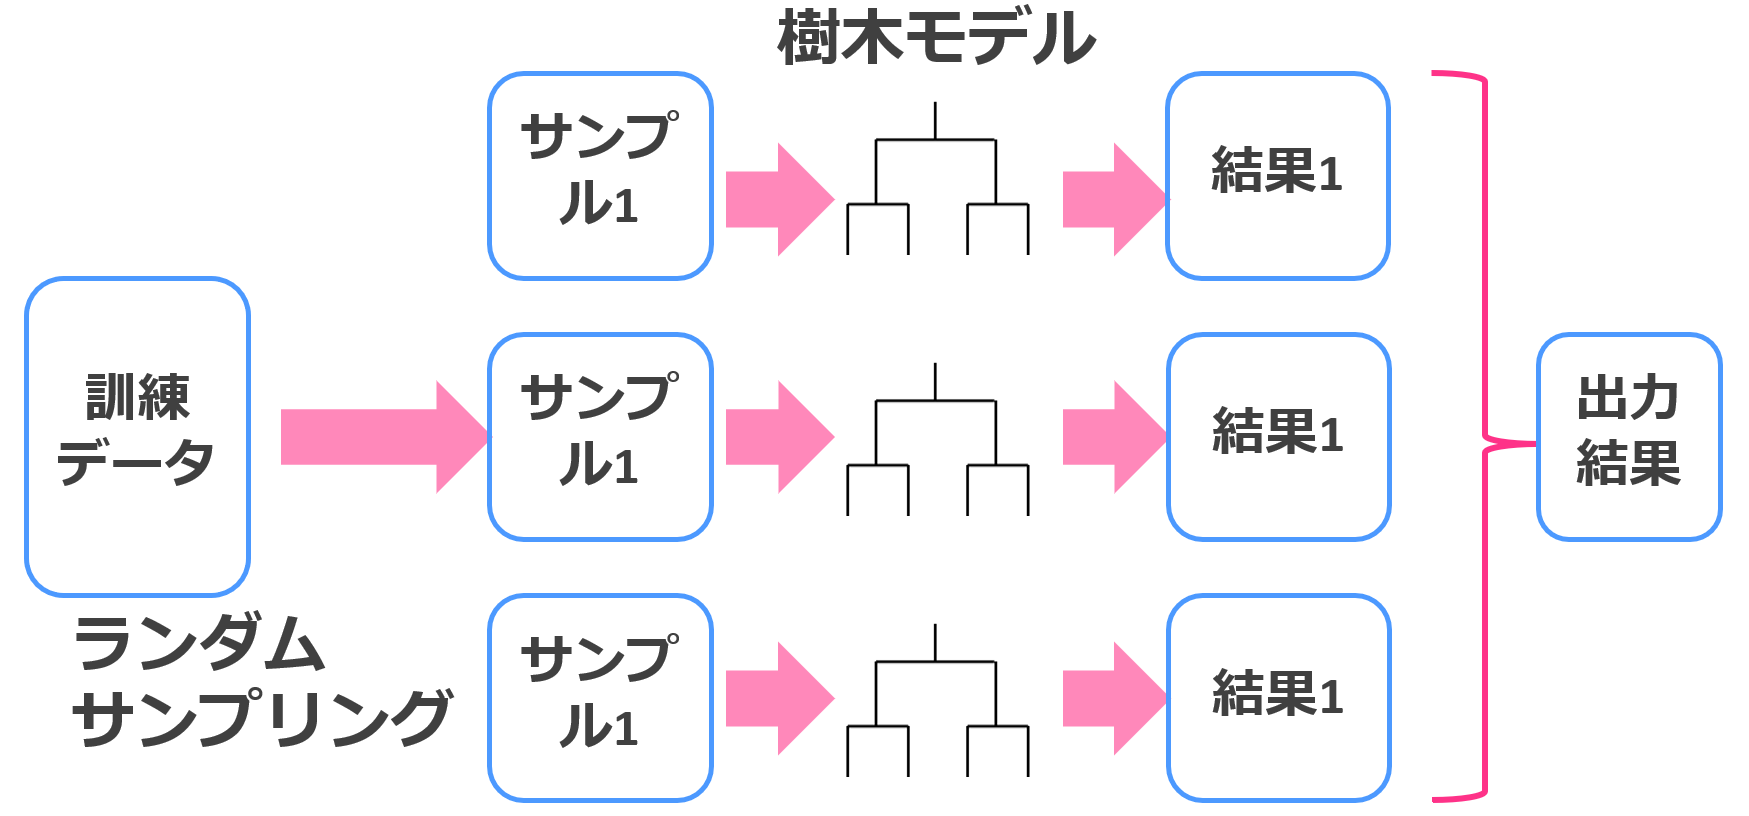

バギング×決定木はランダムフォレストという手法で、こちらも非常に強力な機械学習手法です。

一方、ブースティングとは前の弱学習器が上手く識別できなった部分を重点的に次の弱学習器が学習する直列型のリレーモデル

以下のようなイメージです。

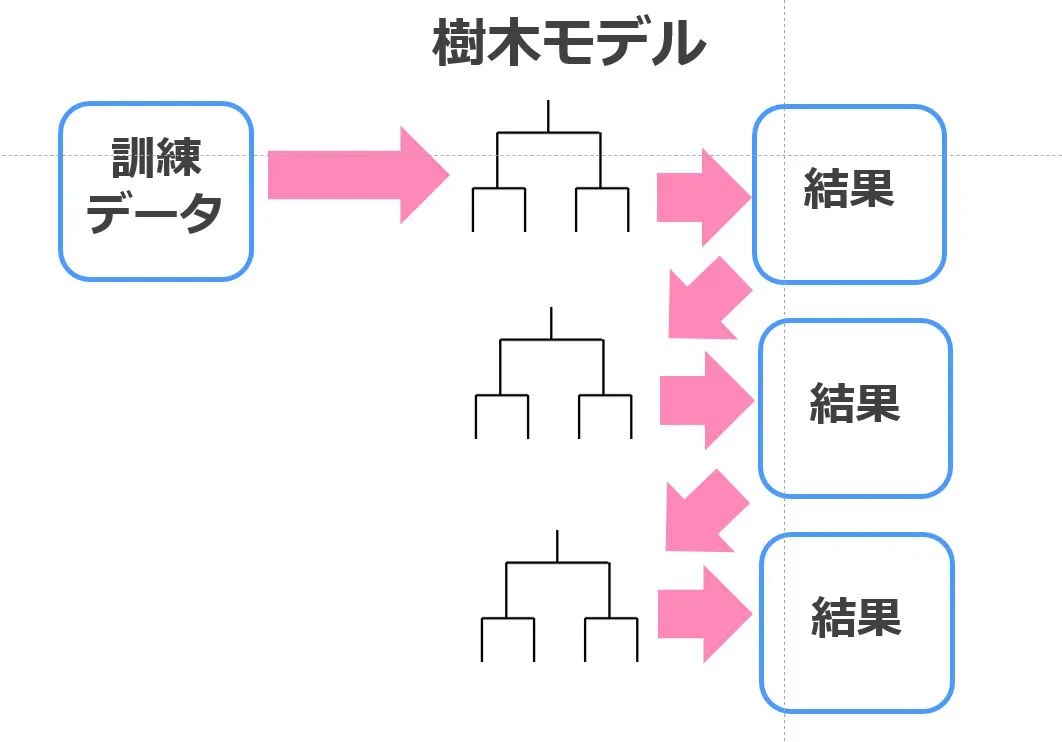

そして、「Xgboost」「LightGBM」「Catboost」はどれもブースティング×決定木との組み合わせなんです。

続いて勾配とは何を示しているのか。

ブースティングを行う際に損失関数というものを定義してなるべく損失が少なくなるようなモデルを構築するのですが、その時使う方法が勾配降下法。

そのため勾配ブースティングと呼ばれているんです。

最適化手法にはいくつか種類がありますが、もし興味のある方は以下の書籍が非常におすすめなのでぜひチェックしてみてください！

## 勾配ブースティングをPythonで実装
勾配ブースティングについてなんとなーくイメージはつかめたでしょうか？

それでは実際に勾配ブースティング手法をPythonで実装して比較していきます！

使用するデータセットは画像識別のベンチマークによく使用されるMnistというデータです。

Mnistは以下のような特徴を持っています。

    ・0~9の手書き数字がまとめられたデータセット
    ・6万枚の訓練データ用（画像とラベル）
    ・1万枚のテストデータ用（画像とラベル）
    ・白「0」～黒「255」の256段階
    ・幅28×高さ28フィールド

ディープラーニングのパフォーマンスをカンタンに測るのによく利用されますね。

## Xgboost
さて、まずはXgboost。

Xgboostは今回比較する勾配ブースティング手法の中でもっとも古い手法です。

基本的にこの後に登場するLightGBMもCatboostもXgboostをもとにして改良を重ねた手法になっています。

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Kerasに付属の手書き数字画像データをダウンロード
np.random.seed(0)
(X_train_base, labels_train_base), (X_test, labels_test) = mnist.load_data()

# Training set を学習データ（X_train, labels_train）と検証データ（X_validation, labels_validation）に8:2で分割する
X_train, X_validation, labels_train, labels_validation = train_test_split(X_train_base, labels_train_base, test_size = 0.2)

# 各画像は行列なので1次元に変換→X_train,X_validation,X_testを上書き
X_train = X_train.reshape(-1,784)
X_validation = X_validation.reshape(-1,784)
X_test = X_test.reshape(-1,784)

#正規化
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_validation /= 255
X_test /= 255

# 訓練・テストデータの設定
train_data = xgb.DMatrix(X_train, label=labels_train)
eval_data = xgb.DMatrix(X_validation, label=labels_validation)
X_data = xgb.DMatrix(X_test, label=labels_test)

#経過時間計測
import time
start = time.time()

xgb_params = {
    # 多値分類問題
    'objective':'multi:softmax',
    # クラス数
    'num_class': 10,
    # 学習用の指標 (Multiclass logloss)
    'eval_metric': 'mlogloss',
    }

evals = [(train_data, 'train'), (eval_data, 'eval')]

gbm = xgb.train(
    xgb_params,
    train_data,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals=evals,
    )

preds = gbm.predict(X_data)

from sklearn.metrics import accuracy_score
print('accuracy_score:{}'.format(accuracy_score(labels_test, preds)))

#経過時間
print('elapsed_timetime:{}'.format(time.time()-start))

[0]	train-mlogloss:1.36144	eval-mlogloss:1.37976
[1]	train-mlogloss:1.02846	eval-mlogloss:1.05534
[2]	train-mlogloss:0.80982	eval-mlogloss:0.84437
[3]	train-mlogloss:0.65517	eval-mlogloss:0.69465
[4]	train-mlogloss:0.54093	eval-mlogloss:0.58554
[5]	train-mlogloss:0.45045	eval-mlogloss:0.50003
[6]	train-mlogloss:0.37916	eval-mlogloss:0.43260
[7]	train-mlogloss:0.32197	eval-mlogloss:0.37788
[8]	train-mlogloss:0.27675	eval-mlogloss:0.33492
[9]	train-mlogloss:0.24008	eval-mlogloss:0.30108
[10]	train-mlogloss:0.21141	eval-mlogloss:0.27424
[11]	train-mlogloss:0.18689	eval-mlogloss:0.25121
[12]	train-mlogloss:0.16618	eval-mlogloss:0.23193
[13]	train-mlogloss:0.14792	eval-mlogloss:0.21512
[14]	train-mlogloss:0.13354	eval-mlogloss:0.20234
[15]	train-mlogloss:0.12111	eval-mlogloss:0.19093
[16]	train-mlogloss:0.10954	eval-mlogloss:0.18034
[17]	train-mlogloss:0.10040	eval-mlogloss:0.17192
[18]	train-mlogloss:0.09171	eval-mlogloss:0.16383
[19]	train-mlogloss:0.08409	eval-mlogloss:0.15700
[20]	train

0.9764は普通に高い精度！！

ただ、学習時間は1410秒なので20分以上かかってます

## Lightgbm
続いて、LightGBM！

LightGBMはXgboostよりも高速に結果を算出することにできる手法！

Xgboostを含む通常の決定木モデルは以下のように階層をあわせて学習していきます。

それをLevel-wiseと呼びます。

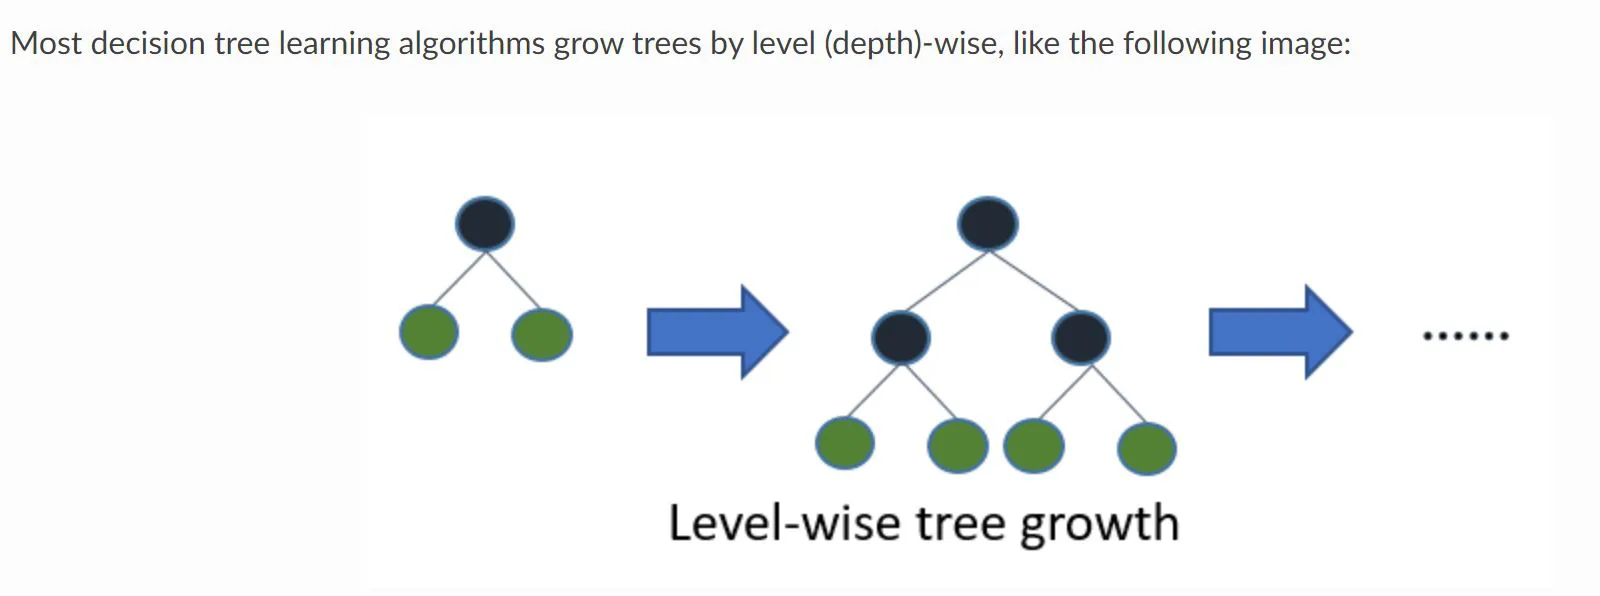

一方Light GBMは以下のように葉ごとの学習を行います。これをleaf-wise法と呼びます。

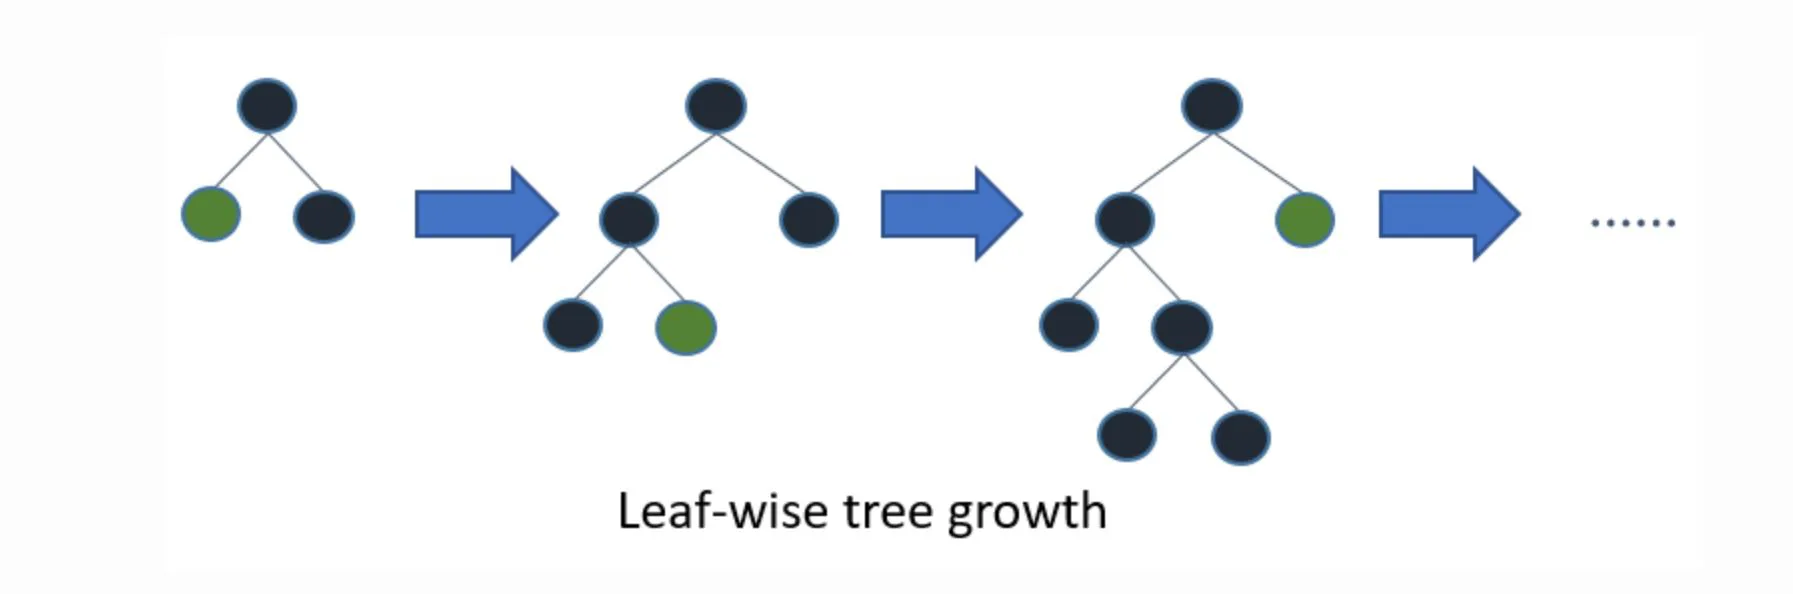

これにより、ムダな学習をしなくても済むためよりXGBoostよりも効率的に学習を進めることができます。

Gradient Boosting Decision Tree (GBDT) is a popular machine learning algorithm, and has quite a few effective implementations such as XGBoost and pGBRT. Although many engineering optimizations have been adopted in these implementations, the efficiency and scalability are still unsatisfactory when the feature dimension is high and data size is large. A major reason is that for each feature, they need to scan all the data instances to estimate the information gain of all possible split points, which is very time consuming.

（引用元：Google-“LightGBM: A Highly Efficient Gradient BoostingDecision Tree”）

In [3]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Kerasに付属の手書き数字画像データをダウンロード
np.random.seed(0)
(X_train_base, labels_train_base), (X_test, labels_test) = mnist.load_data()

# Training set を学習データ（X_train, labels_train）と検証データ（X_validation, labels_validation）に8:2で分割する
X_train,X_validation,labels_train,labels_validation = train_test_split(X_train_base,labels_train_base,test_size = 0.2)

# 各画像は行列なので1次元に変換→X_train,X_validation,X_testを上書き
X_train = X_train.reshape(-1,784)
X_validation = X_validation.reshape(-1,784)
X_test = X_test.reshape(-1,784)

#正規化
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_validation /= 255
X_test /= 255

# 訓練・検証データの設定
train_data = lgb.Dataset(X_train, label=labels_train)
eval_data = lgb.Dataset(X_validation, label=labels_validation, reference= train_data)

#経過時間計測
import time
start = time.time()

#light gbm モデル構築
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'multiclass',
'num_class': 10,
}

gbm = lgb.train(
params,
train_data,
valid_sets=eval_data,
num_boost_round=100
# early_stopping_rounds=10,
)

preds = gbm.predict(X_test)
preds

y_pred = []
for x in preds:
  y_pred.append(np.argmax(x))

from sklearn.metrics import accuracy_score
print('accuracy_score:{}'.format(accuracy_score(labels_test, y_pred)))

#経過時間
print('elapsed_timetime:{}'.format(time.time()-start))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.521631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106940
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 621
[LightGBM] [Info] Start training from score -2.319816
[LightGBM] [Info] Start training from score -2.191677
[LightGBM] [Info] Start training from score -2.304253
[LightGBM] [Info] Start training from score -2.277283
[LightGBM] [Info] Start training from score -2.325982
[LightGBM] [Info] Start training from score -2.401945
[LightGBM] [Info] Start training from score -2.317699
[LightGBM] [Info] Start training from score -2.254390
[LightGBM] [Info] Start training from score -2.332186
[LightGBM] [Info] Start training from score -2.314320
accuracy_score:0.9766
elapsed_timetime:148.36214327812195


Light gbmは、0.972！若干Xgboostよりも低い精度になりました。

ただ、学習時間は178秒なので、なんとXgboostよりも8分の1ほどに短くなっています！

データサイエンスの特徴量精査のフェーズにおいて学習時間は非常に大事なので、この違いは大きいですねー！

## Catboost
続いて、Catboost！

Catboostは、「Category　Boosting」の略であり2017年にYandex社から発表された機械学習ライブラリ。

発表時期としてはLightGBMよりも若干後になっています。

Catboostは質的変数の扱いに上手く、他の勾配ブースティング手法よりも高速で高い精度を出力できることが論文では示されています。

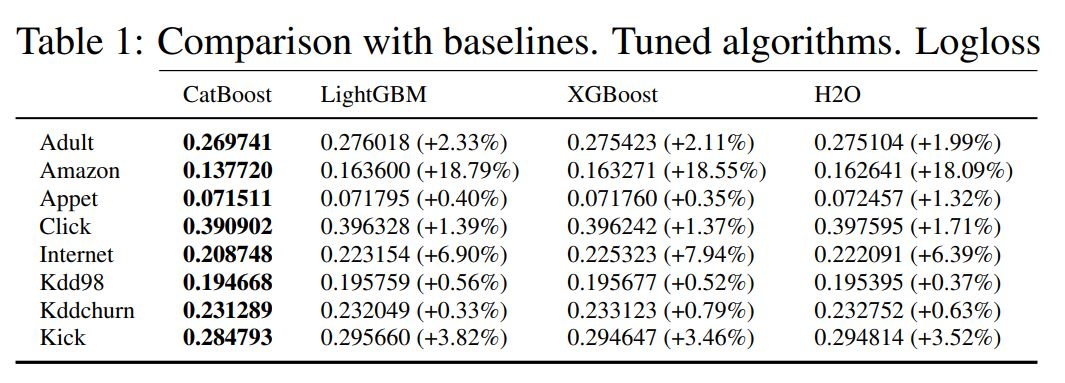

In [5]:
# pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Kerasに付属の手書き数字画像データをダウンロード
np.random.seed(0)
(X_train_base, labels_train_base), (X_test, labels_test) = mnist.load_data()

# Training set を学習データ（X_train, labels_train）と検証データ（X_validation, labels_validation）に8:2で分割する
X_train,X_validation,labels_train,labels_validation = train_test_split(X_train_base,labels_train_base,test_size = 0.2)

# 各画像は行列なので1次元に変換→X_train,X_validation,X_testを上書き
X_train = X_train.reshape(-1,784)
X_validation = X_validation.reshape(-1,784)
X_test = X_test.reshape(-1,784)

#正規化
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_validation /= 255
X_test /= 255

# 訓練・テストデータの設定
from catboost import Pool

train_pool = Pool(X_train, labels_train)
validate_pool = Pool(X_validation, labels_validation)

#経過時間計測
import time
start = time.time()

from catboost import CatBoostClassifier
params = {
    'early_stopping_rounds' : 10,
    'iterations' : 100,
    'custom_loss' :['Accuracy'],
    'random_seed' :42
}
# パラメータを指定した場合は、以下のようにインスタンスに適用させる
model = CatBoostClassifier(**params)
cab = model.fit(train_pool, eval_set=validate_pool)
preds = cab.predict(X_test)
from sklearn.metrics import accuracy_score
print('accuracy_score:{}'.format(accuracy_score(labels_test, preds)))

#経過時間
print('elapsed_timetime:{}'.format(time.time()-start))

Learning rate set to 0.281159
0:	learn: 1.5746723	test: 1.5731968	best: 1.5731968 (0)	total: 3.2s	remaining: 5m 17s
1:	learn: 1.3228033	test: 1.3252472	best: 1.3252472 (1)	total: 7.96s	remaining: 6m 30s
2:	learn: 1.0915287	test: 1.0978054	best: 1.0978054 (2)	total: 15.2s	remaining: 8m 10s
3:	learn: 0.9608848	test: 0.9668624	best: 0.9668624 (3)	total: 21.5s	remaining: 8m 36s
4:	learn: 0.8517554	test: 0.8575492	best: 0.8575492 (4)	total: 28.9s	remaining: 9m 8s
5:	learn: 0.7708352	test: 0.7775942	best: 0.7775942 (5)	total: 31.8s	remaining: 8m 18s
6:	learn: 0.7033119	test: 0.7110318	best: 0.7110318 (6)	total: 34.8s	remaining: 7m 42s
7:	learn: 0.6549993	test: 0.6621621	best: 0.6621621 (7)	total: 39.4s	remaining: 7m 32s
8:	learn: 0.5982515	test: 0.6061512	best: 0.6061512 (8)	total: 42.3s	remaining: 7m 8s
9:	learn: 0.5470616	test: 0.5542339	best: 0.5542339 (9)	total: 45.3s	remaining: 6m 47s
10:	learn: 0.5113016	test: 0.5185901	best: 0.5185901 (10)	total: 48.3s	remaining: 6m 30s
11:	learn: 0.4

精度は、0.9567・・

処理時間は260秒・・

何とも中途半端な結果におわってしまいましたー！

総合的に見ると、LightGBMが最も高速で実践的。

ただデータセットによって精度の良し悪しは変わるので、どんなデータでもこの手法の精度が高い！ということは示せない。

# 勾配ブースティングまとめ
勾配ブースティングについて徹底的に比較してきました！

やはりLightGBMが最も高速で実用的なようです。

Xgboostはデータセットが膨大な場合、処理時間がかかり過ぎて実用的じゃなくなるケースがあります。